In [38]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import os

In [84]:
progresses = []
for dirname, _, filenames in os.walk('output'):
    for filename in filenames:
        if 'progress' in filename:
            progresses.append(os.path.join(dirname, filename))
            print(os.path.join(dirname, filename))

output/humanoid-dir/2020_02_04_21_55_51/progress.csv
output/humanoid-dir/2020_02_04_12_53_44/progress.csv
output/humanoid-dir/2020_02_05_00_34_04/progress.csv
output/humanoid-dir/2020_02_05_00_35_33/progress.csv
output/dgx-humanoid-dir/2020_02_04_12_53_44/progress.csv


In [89]:
results = pd.read_csv(progresses[3], skiprows=[1])
results['Number of env steps total']

0     211642
1     216969
2     222242
3     227560
4     232826
       ...  
77    633564
78    639025
79    644737
80    650147
81    655734
Name: Number of env steps total, Length: 82, dtype: int64

In [68]:
results.columns

Index(['Z mean train', 'Z variance train', 'KL Divergence', 'KL Loss',
       'QF Loss', 'VF Loss', 'Policy Loss', 'Q Predictions Mean',
       'Q Predictions Std', 'Q Predictions Max', 'Q Predictions Min',
       'V Predictions Mean', 'V Predictions Std', 'V Predictions Max',
       'V Predictions Min', 'Log Pis Mean', 'Log Pis Std', 'Log Pis Max',
       'Log Pis Min', 'Policy mu Mean', 'Policy mu Std', 'Policy mu Max',
       'Policy mu Min', 'Policy log std Mean', 'Policy log std Std',
       'Policy log std Max', 'Policy log std Min', 'Decoder Loss',
       'Mean Intrinsic Reward', 'Z mean eval', 'Z variance eval',
       'AverageTrainReturn_all_train_tasks', 'AverageReturn_all_train_tasks',
       'AverageReturn_all_test_tasks', 'Number of train steps total',
       'Number of env steps total', 'Number of rollouts total',
       'Train Time (s)', '(Previous) Eval Time (s)', 'Sample Time (s)',
       'Epoch Time (s)', 'Total Train Time (s)', 'Epoch'],
      dtype='object')

In [69]:
print('Total steps', results['Number of train steps total'][len(results['Number of train steps total']) - 1])
print('Train time', results['Total Train Time (s)'][len(results['Total Train Time (s)']) - 1])
results['Decoder Loss']

Total steps 332000
Train time 35954.012373284015


0     88.463211
1     85.291618
2     78.464111
3     72.421799
4     73.151428
        ...    
77    56.384399
78    57.449913
79    59.839935
80    56.828747
81    53.243614
Name: Decoder Loss, Length: 82, dtype: float64

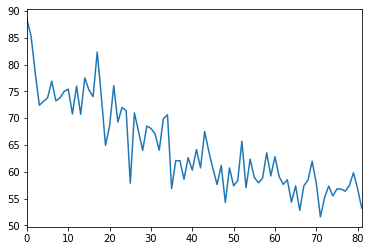

In [70]:
#fig, axs = plt.subplots(1,2)
results['Decoder Loss'].plot.line() # ax=axs[0]

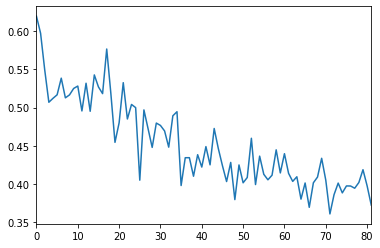

In [71]:
results['Mean Intrinsic Reward'].plot.line()

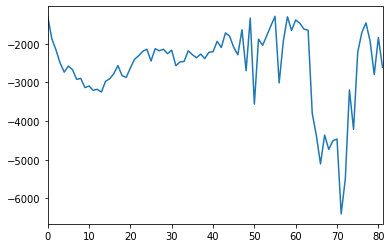

In [72]:
results['Policy Loss'].plot.line()

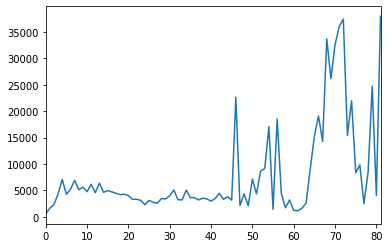

In [73]:
results['VF Loss'].plot.line()

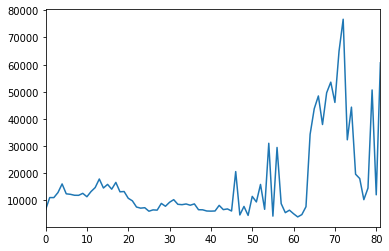

In [74]:
results['QF Loss'].plot.line()

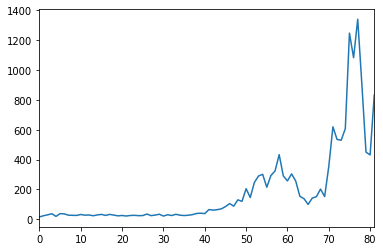

In [75]:
results['KL Loss'].plot.line()

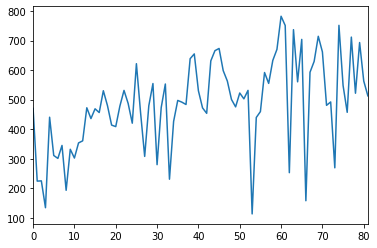

In [76]:
results['AverageReturn_all_train_tasks'].plot.line()

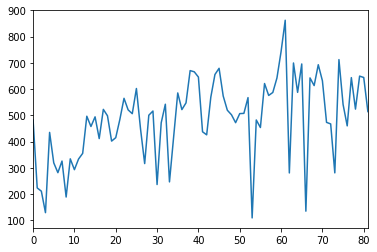

In [77]:
results['AverageReturn_all_test_tasks'].plot.line()

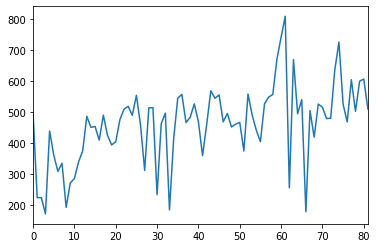

In [78]:
results['AverageTrainReturn_all_train_tasks'].plot.line()